# Formation Pratique 9 - Réduction de dimensionalité
### Sujets abordés :
- PCA
- MDS/PCoA
- LLE
- Isomap

## Réduction de dimensionalités non-linéaire

Bien que PCA soit rapide et facilement calculable, nous allons voir que cette méthode ne s'applique pas très bien lorsque nous avons des relations non-linéaires entre des données.

Pour comprendre ce problème, créons notre propre jeu de données:

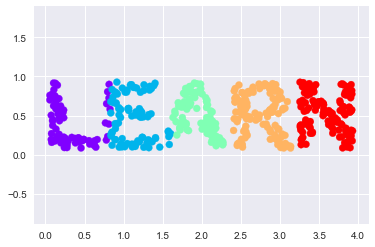

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set() 
import numpy as np

def make_data(N=1000, rseed=3700):
    # Produit un scatter-plot qui forme les lettres 'LEARN'
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'LEARN', va='center', ha='center', weight='bold', size=85)
    fig.savefig('data.png')
    plt.close(fig)

    # Ouvre le fichier png et dessine des points aléatoires
    from matplotlib.image import imread 
    data = imread('data.png')[::-1, :, 0].T 
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T 
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1]) 
    X = X[:N]
    return X[np.argsort(X[:, 0])]


X = make_data(500)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

Nous avons donc le mot "LEARN" composé de 500 points en deux dimensions. Évidemment, puisque nous connaissons la forme de ces lettres, nous comprenons les relations qui existent entre ces données. Nous pouvons donc modifier cette figure en faisant une translation, rotation ou un agrandissement et nous serions tout de même capable de lire le mot "LEARN". Une telle transformation ne **changerait donc pas l'information que représente ces données**. Nous effectuons donc une rotation à titre d'exemple :

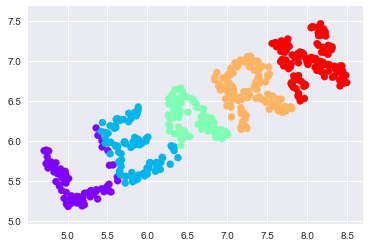

In [ ]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

X2 = rotate(X, 25) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

Ce que nous venons d'illustrer est que les valeurs x et y des données ne sont pas essentielles pour représenter les relations entre ces dernières. Ce qui serait essentiel dans ce cas serait **les distances entre chaque points dans le jeu de données**. Nous pouvons utiliser une matrice de distances pour les représenter, soit une matrice $N \times N$ telle que l'entrée $a_{ij}$ contient la distance entre le point $i$ et le point $j$ :

In [ ]:
from sklearn.metrics import pairwise_distances 
D = pairwise_distances(X)
D.shape

(500, 500)

Nous pouvons visualiser cette matrice comme suit :

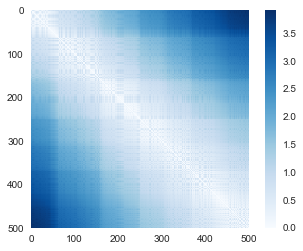

In [ ]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

Si nous calculons notre matrice de distances à partir de nos données une fois la rotation faite, nous obtenons évidemment le même résultat :

In [ ]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

Bien que la matrice de distances soit invariante à l'opération de rotation, nous ne pouvons pas visualiser les données qui la génère de manière intuitive.

## 9.1 MDS (Multi Dimensional Scaling) / PCoA (Principle Coordinates Analysis)

MDS, aussi appelé le positionnement multidimensionnel, vise à explorer et visualiser les similaritées entre les données. En bref, cet algorithme prends en entrée une matrice de distances et assigne à chaque entrée de la matrice une position en espace de petite dimensionalité (2-D ou 3-D).

Voir ce fichier très pertinent pour comprendre le fonctionnement de MDS: [pour les braves](http://www.cs.umd.edu/~djacobs/CMSC828/MDSexplain.pdf)

Maintenant que nous comprenons cet algorithme, nous pourrions l'utiliser pour retrouver notre graphique du mot "LEARN" à partir de la matrice de distances D2 que nous venons de calculer :

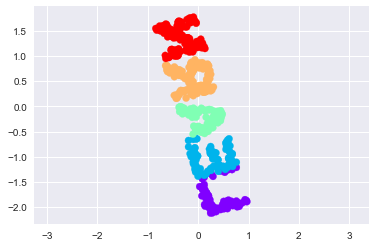

In [ ]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1) 
out = model.fit_transform(D2)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

Nous voyons donc que ce qu'on obtient une représentation possible en deux dimension de nos données malgré le fait qu'il ne s'agit pas de ce que nous avions plus tôt. Il s'agit d'un résultat **cohérent** puisque nous pouvons toujours observer la relation entre les données, même si ces dernières sont postionnées différement. 

Ce que nous venons d'accomplir est aussi possible en n'importe quel nombre de dimensions. Voici un autre exemple où nous projetons ces données en trois dimensions :

In [ ]:
def random_projection(X, dimension=3, rseed=42): 
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension) 
    e, V = np.linalg.eigh(np.dot(C, C.T)) 
    return np.dot(X, V[:X.shape[1]])
           
X3 = random_projection(X, 3)
X3.shape

(500, 3)

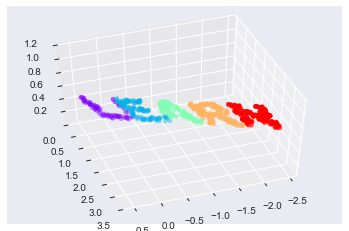

In [ ]:
from mpl_toolkits import mplot3d 
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],**colorize)
ax.view_init(azim=70, elev=50)

Nous pouvons effectuer les mêmes manipulations que plus tôt, ce qui nous donne :

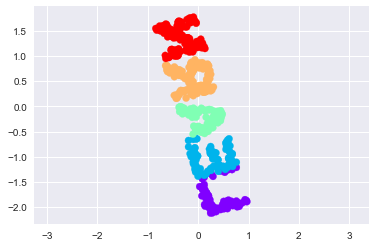

In [ ]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

Nous voyons donc que MDS fonctionne à partir de n'importe quelle dimension, puisque notre point de départ est seulement une **matrice de distances**. Nous avons ci-dessus le même résultat puisque nos distances furent préservées lorsque nous avons projeté nos données en 3-D. 

Jusqu'à maintenant, nous pouvons voir que ces manipulations nous donne des résultats qui sont relativement cohérents puisque la transformation que nous avons effectué (rotation) est une transformation **linéaire**. En supposant que nous n'avions pas de relations non-linéaires auparavant, la transformation linéaire que nous effectuons n'introduit pas de non-linéarité dans notre jeu de données. 

Voici ce que nous aurions avec une transformation non-linéaire :

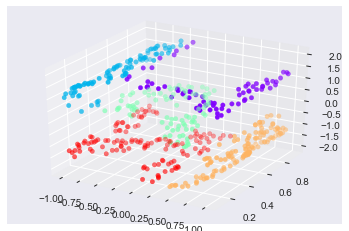

In [ ]:
def make_s_curve(X): 
    t=(X[:,0]-2)*0.75*np.pi
    x = np.sin(t)
    y=X[:,1]
    z = np.sign(t) * (np.cos(t) - 1) 
    return np.vstack((x, y, z)).T

XS = make_s_curve(X)

from mpl_toolkits import mplot3d 
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],**colorize);

Ce que nous avons plus haut sont nos lettres du mot "LEARN" qui forment une spirale en forme de "S". Les points supérieurs proviennent de la lettre "L" qui est à l'envers et les autres lettres serpentinent vers le bas jusqu'à la lettre "N" qui est à l'envers également. Voyons voir ce que nous obtenons avec le même code que celui utilisé précédemment :

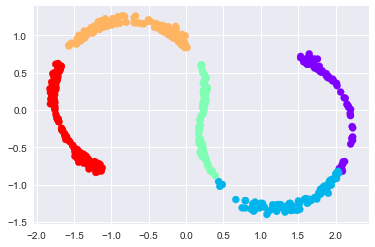

In [ ]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2) 
outS = model.fit_transform(XS) 
plt.scatter(outS[:, 0], outS[:, 1], **colorize) 
plt.axis('equal');

Nous voyons donc que ce résultat est beaucoup moins cohérent; il est impossible de décerner même une seule lettre. Ce résultat est incohérent puisque MDS tente de préserver les distances entre **tout** les points alors que dans ce cas-ci il serait plus pertinent de préserver les distances entre les points les plus proches. Ceci permettrait de **déplier** le "S" :

![Figure 1](figure1.png)

## 9.2 LLE (LOCALLY LINEAR EMBEDDING)

Le but de LLE est de retrouver une projection de basse dimensionalité qui préserve les distances entre les **voisins locaux** des données. Cette algorithme contient trois stages :

1. Recherche des voisins les plus proches.
2. Construction de matrice de poids qui réduit la valeur d'une fonction objectif.
3. Trouver le plongement (embedding) de basse dimensionalité qui est le mieux construit à partir des poids déterminés lors de l'étape 2.


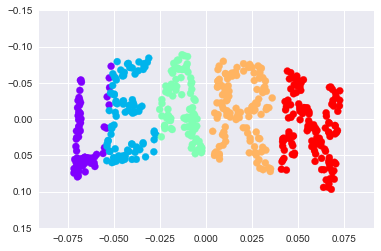

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=29, n_components=2, method='modified',eigen_solver='dense')
out = model.fit_transform(XS)
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

La figure ci-dessus démontre que LLE a "déplié" notre "manifold" en forme de "S" avec succès. Nous pouvons à nouveau lire le mot "LEARN". L'hyper-paramètre de cet algorithme est évidemment le nombre de voisins les plus proches à considérer. Nous obtenons un bon résultat en choisissant 29 pour `n_neighbors`. Je vous invite à observer ce qui arrive lorsqu'on modifie la valeur de `n_neighbors`.

## 9.3 ISOMAP (Isometric Mapping)

Isomap (isometric mapping) est une autre méthode de réduction de dimensionalité non-linéaire qui est basée sur le principe de la conservation des distances entre les données en plus hautes dimensions **telles que mesurées sur le "manifold" qui contient ces dernières**. Voici l'algorithme :

1. Recherche des voisins les plus proches.
2. Calcul de la distance géodésique pair à pair entre tout les points.
3. Utiliser MDS pour trouver le ploengement qui préserve ces distances.

Nous utilisons le jeux de données LFW (Labeled Faces in the Wild) à titre d'exemple.

In [ ]:
from sklearn.datasets import fetch_lfw_people 
faces = fetch_lfw_people(min_faces_per_person=30) 
faces.data.shape

(2370, 2914)

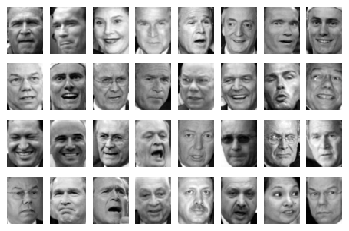

In [ ]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[])) 
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


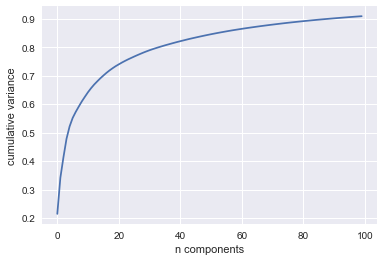

In [ ]:
from sklearn.decomposition import RandomizedPCA 

model = RandomizedPCA(100).fit(faces.data) 
plt.plot(np.cumsum(model.explained_variance_ratio_)) 
plt.xlabel('n components')
plt.ylabel('cumulative variance');

La figure ci-dessus nous indique que nous avons besoin d'environ 100 composantes pour préserver 90% de la variance.

In [ ]:
from sklearn.manifold import Isomap 
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

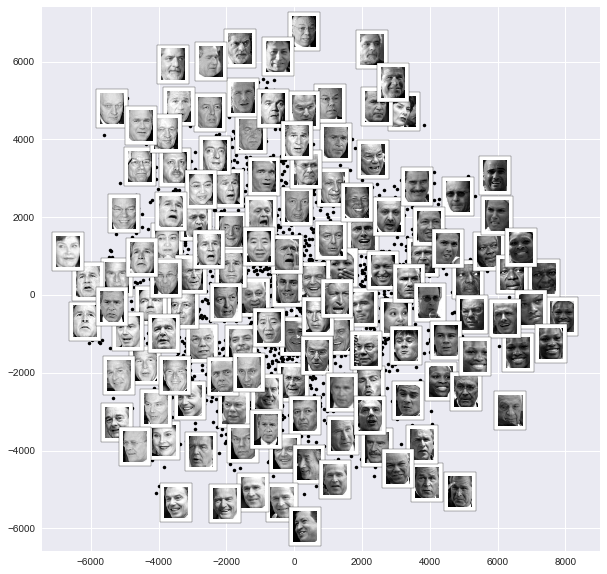

In [ ]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
    
    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2 
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1) 
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue

            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                                  proj[i])
            ax.add_artist(imagebox)

fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,model=Isomap(n_components=2),images=faces.images[:, ::2, ::2])

Nous pouvons donc visualiser nos données. Les deux dimensions que nous semblons avoir sont: la luminosité sur l'axe horizontal et l'orientation (gauche/droite) sur l'axe vertical. 

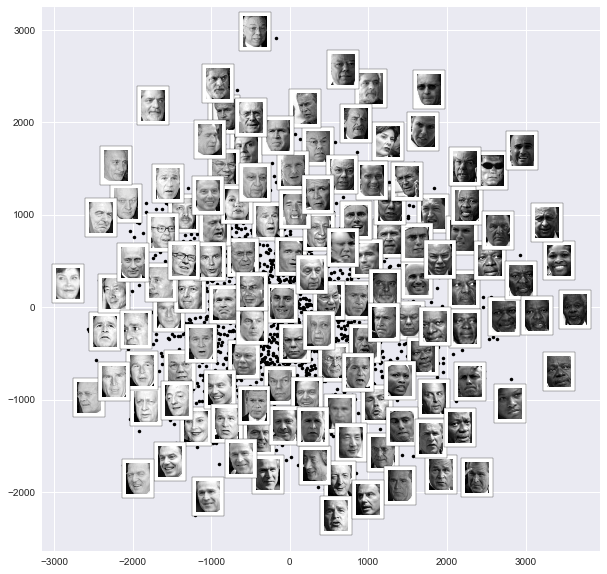

In [ ]:
from sklearn.decomposition import PCA 
model = PCA(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray'):
    
    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2 
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1) 
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue

            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                                  proj[i])
            ax.add_artist(imagebox)

fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,model=PCA(n_components=2),images=faces.images[:, ::2, ::2])